In [1]:
import numpy as np 
import pandas as pd
import re
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
import contractions 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

In [2]:
train = pd.read_csv('train.csv')

print(f'length {len(train): 9}')
print(train.isnull().sum())
train.head()

length      7613
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test = pd.read_csv('test.csv')

print(f'length {len(test): 9}')
print(test.isnull().sum())
test.head()

length      3263
id             0
keyword       26
location    1105
text           0
dtype: int64


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Data Cleaning & Feature Engineering

In [4]:
train['text_clean'] = train['text']
test['text_clean'] = test['text']                              

In [5]:
# cleaning: lowercase
train['text_clean'] = train['text_clean'].apply(lambda x: x.lower())
test['text_clean'] = test['text_clean'].apply(lambda x: x.lower())

# cleaning: expand contractions
train['text_clean'] = train['text_clean'].apply(lambda x: contractions.fix(x))
test['text_clean'] = test['text_clean'].apply(lambda x: contractions.fix(x))

# cleaning: remove accents and special characters
train['text_clean'] = (train['text_clean']
                       .str.normalize('NFKD')
                       .str.encode('ascii', errors='ignore')
                       .str.decode('utf-8'))
test['text_clean'] = (test['text_clean']
                      .str.normalize('NFKD')
                      .str.encode('ascii', errors='ignore')
                      .str.decode('utf-8'))

# cleaning: remove URLS
train['text_clean'] = train['text_clean'].apply(lambda x: re.sub(r'https?:\/\/t.co\/[\w]+', '', x))
test['text_clean'] = test['text_clean'].apply(lambda x: re.sub(r'https?:\/\/t.co\/[\w]+', '', x))

# cleaning: remove digits
train['text_clean'] = train['text_clean'].apply(lambda x: re.sub(r'[\d+,*\d+]', '', x))
test['text_clean'] = test['text_clean'].apply(lambda x: re.sub(r'[\d+,*\d+]', '', x))

# cleaning: remove stopwords
stop = stopwords.words('english')
train['text_clean'] = train['text_clean'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in stop]))
test['text_clean'] = test['text_clean'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in stop]))  

In [6]:
## Initially, the location was used as a feature. However, this adversely
## affected the model, which is why it is excluded.

# import pycountry
# from sklearn.preprocessing import LabelEncoder
#
# country_list = [country.name for country in pycountry.countries]
# sub_country_list = [subcountry.name for subcountry in pycountry.subdivisions]
# country_list.extend(sub_country_list)

# country_list2 = '|'.join(country_list)

# loc_list_train = []
# for entry in train['text_clean']:
#     match =  re.search(country_list2, entry)
#     if match:
#         loc_list_train.append(match.group())
#     else:
#         loc_list_train.append('Other')
        
# loc_list_test = []
# for entry in test['text_clean']:
#     match =  re.search(country_list2, entry)
#     if match:
#         loc_list_test.append(match.group())
#     else:
#         loc_list_test.append('Other')
        
# train['location_extract'] = loc_list_train
# test['location_extract'] = loc_list_test

# train['location_final'] = train['location'].combine_first(train['location_extract'])
# train['location_final'] = (train['location_final']
#                            .apply(lambda x: x.split(',')[0])
#                            .apply(lambda x: x.lower())
#                            .apply(lambda x: re.sub(r'[_\W]', ' ', x)))

# test['location_final'] = test['location'].combine_first(test['location_extract'])
# test['location_final'] = (test['location_final']
#                           .apply(lambda x: x.split(',')[0])
#                           .apply(lambda x: x.lower())
#                           .apply(lambda x: re.sub(r'[_\W]', ' ', x)))

# train['location_n'] = LabelEncoder().fit_transform(train.loc[:,'location_final'])
# test['location_n'] = LabelEncoder().fit_transform(test.loc[:,'location_final'])

In [7]:
# tweet tokenizer
train['tweet_tokens'] = train['text_clean'].apply(
    lambda x: TweetTokenizer().tokenize(x))
test['tweet_tokens'] = test['text_clean'].apply(
    lambda x: TweetTokenizer().tokenize(x))

In [8]:
# cleaning: remove mentions
train['text_clean'] = train['text_clean'].apply(lambda x: re.sub(r'@[\w]+', '', x))
test['text_clean'] = test['text_clean'].apply(lambda x: re.sub(r'@[\w]+', '', x))

# cleaning: remove punctuation
train['text_clean'] = train['text_clean'].apply(lambda x: re.sub(r'[_\W]', ' ', x))
test['text_clean'] = test['text_clean'].apply(lambda x: re.sub(r'[_\W]', ' ', x))

# cleaning: create tokens
train['text_tokens'] = train['text_clean'].apply(lambda x: word_tokenize(x))
test['text_tokens'] = test['text_clean'].apply(lambda x: word_tokenize(x))

# remove unicode characters
train['text_clean'] = train['text_clean'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
test['text_clean'] = test['text_clean'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# remove extra spaces
train['text_clean'] = train['text_clean'].apply(lambda x: re.sub(r'\s+', ' ', x))
test['text_clean'] = test['text_clean'].apply(lambda x: re.sub(r'\s+', ' ', x))
train['text_clean'] = train['text_clean'].str.strip()
test['text_clean'] = test['text_clean'].str.strip()

In [9]:
# spelling correction: word length
def reduce(text):
    pattern = re.compile(r'(.)\1{3,}')
    return pattern.sub(r'\1\1', text)

train['text_clean'] = train['text_clean'].apply(lambda x: reduce(x))
test['text_clean'] = test['text_clean'].apply(lambda x: reduce(x))

In [10]:
train['ch_n'] = train['text'].str.len()
test['ch_n'] = test['text'].str.len()

train['digit_n'] = train['text'].apply(lambda row: len(re.findall(r'(\d)', row)))
test['digit_n'] = test['text'].apply(lambda row: len(re.findall(r'(\d)', row)))

train['alpha_n'] = train['text'].apply(lambda row: len(re.findall(r'(\w)', row)))
test['alpha_n'] = test['text'].apply(lambda row: len(re.findall(r'(\w)', row)))

train['non_alpha_n'] = train['text'].apply(lambda row: len(re.findall(r'(\W)', row)))
test['non_alpha_n'] = test['text'].apply(lambda row: len(re.findall(r'(\W)', row)))

train['word_n'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_n'] = test['text'].apply(lambda x: len(str(x).split()))

train['hashtag_n'] = train['text'].apply(lambda row: len(re.findall(r'#(\w)', row)))
test['hashtag_n'] = test['text'].apply(lambda row: len(re.findall(r'#(\w)', row)))

train['mention_n'] = train['text'].apply(lambda row: len(re.findall(r'@(\w)', row)))
test['mention_n'] = test['text'].apply(lambda row: len(re.findall(r'@(\w)', row)))

train['url_n'] = train['text'].apply(lambda row: len(re.findall(r'(http)', row)))
test['url_n'] = test['text'].apply(lambda row: len(re.findall(r'(http)', row)))

train['clean_ch_n'] = train['text_clean'].str.len()
test['clean_ch_n'] = test['text_clean'].str.len()

train['word_tweet_n'] = train['tweet_tokens'].str.len()
test['word_tweet_n'] = test['tweet_tokens'].str.len()

train['word_token_n'] = train['text_tokens'].str.len()
test['word_token_n'] = test['text_tokens'].str.len()

In [11]:
train.head()

,id,keyword,location,text,target,text_clean,tweet_tokens,text_tokens,ch_n,digit_n,alpha_n,non_alpha_n,word_n,hashtag_n,mention_n,url_n,clean_ch_n,word_tweet_n,word_token_n
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,"[deeds, reason, #earthquake, may, allah, forgi...","[deeds, reason, earthquake, may, allah, forgiv...",69,0,56,13,13,1,0,0,44,7,7
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, canada]",38,0,31,7,7,0,0,0,37,8,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,"[residents, asked, ', shelter, place, ', notif...","[residents, asked, shelter, place, notified, o...",133,0,109,24,22,0,0,0,88,14,11
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,"[people, receive, #wildfires, evacuation, orde...","[people, receive, wildfires, evacuation, order...",65,5,55,10,8,1,0,0,53,6,6
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, #alaska, smoke, #wild...","[got, sent, photo, ruby, alaska, smoke, wildfi...",88,0,70,18,16,2,0,0,55,9,9


In [12]:
train.tail()

,id,keyword,location,text,target,text_clean,tweet_tokens,text_tokens,ch_n,digit_n,alpha_n,non_alpha_n,word_n,hashtag_n,mention_n,url_n,clean_ch_n,word_tweet_n,word_token_n
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...,"[two, giant, cranes, holding, bridge, collapse...","[two, giant, cranes, holding, bridge, collapse...",83,1,68,15,11,0,0,1,53,8,8
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,control wild fires california even northern pa...,"[@aria_ahrary, @thetawniest, control, wild, fi...","[control, wild, fires, california, even, north...",125,0,102,23,20,0,2,0,64,13,9
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utc km volcano hawaii,"[m, ., [:, utc, ], ?, km, volcano, hawaii, .]","[m, utc, km, volcano, hawaii]",65,9,47,18,8,0,0,1,23,10,5
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating e bike collided car littl...,"[police, investigating, e-bike, collided, car,...","[police, investigating, e, bike, collided, car...",137,0,114,23,19,0,0,0,116,16,17
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,latest homes razed northern california wildfir...,"[latest, :, homes, razed, northern, california...","[latest, homes, razed, northern, california, w...",94,2,75,19,13,0,0,1,56,10,8


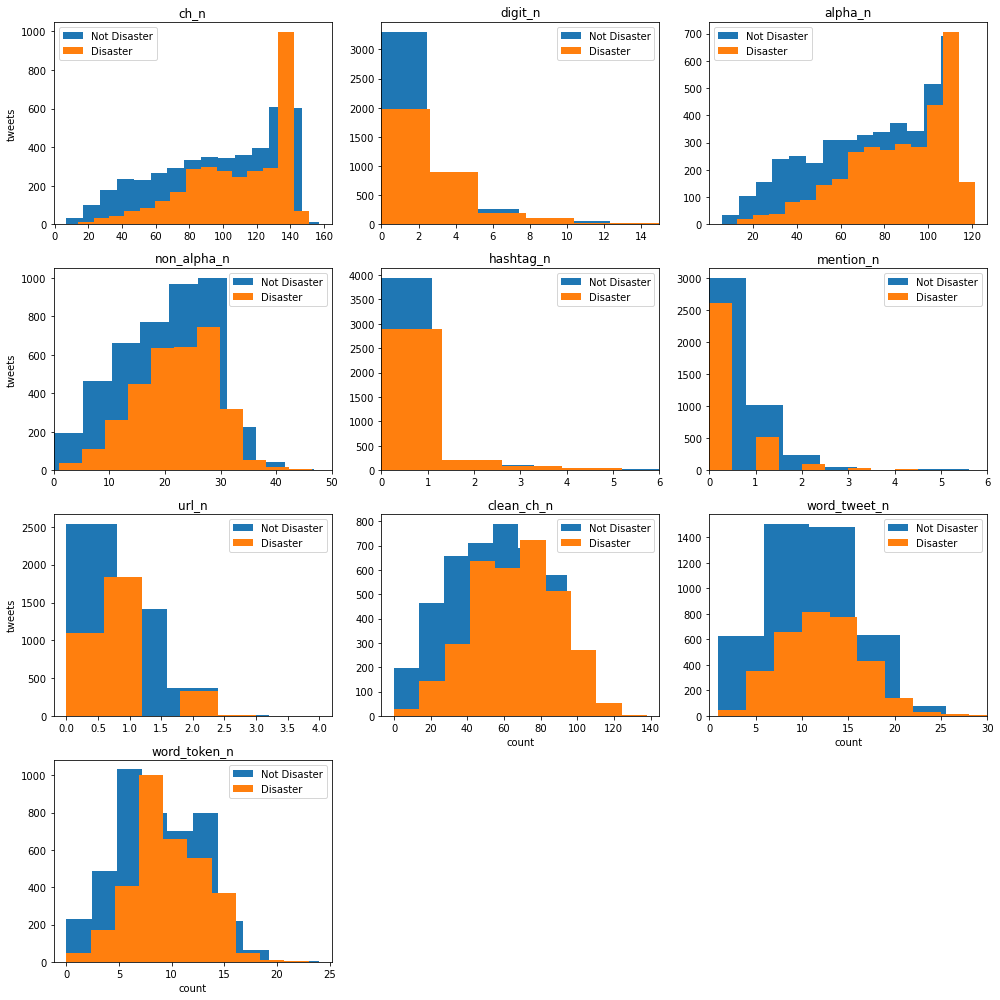

In [13]:
plt.figure(figsize=[14,14])

ax1 = plt.subplot(4,3,1)
ax1.hist(train[train['target'] == 0]['ch_n'], bins=15, label="Not Disaster")
ax1.hist(train[train['target'] == 1]['ch_n'], bins=15, label="Disaster")
ax1.legend()
ax1.set_title('ch_n')
ax1.set_ylabel('tweets')

ax2 = plt.subplot(4,3,2)
ax2.hist(train[train['target'] == 0]['digit_n'], bins=15, label="Not Disaster")
ax2.hist(train[train['target'] == 1]['digit_n'], bins=15, label="Disaster")
ax2.set_xlim([0, 15])
ax2.legend()
ax2.set_title('digit_n')

ax3 = plt.subplot(4,3,3)
ax3.hist(train[train['target'] == 0]['alpha_n'], bins=15, label="Not Disaster")
ax3.hist(train[train['target'] == 1]['alpha_n'], bins=15, label="Disaster")
ax3.legend()
ax3.set_title('alpha_n')

ax4 = plt.subplot(4,3,4)
ax4.hist(train[train['target'] == 0]['non_alpha_n'], bins=15, label="Not Disaster")
ax4.hist(train[train['target'] == 1]['non_alpha_n'], bins=15, label="Disaster")
ax4.set_xlim([0, 50])
ax4.legend()
ax4.set_title('non_alpha_n')
ax4.set_ylabel('tweets')

ax5 = plt.subplot(4,3,5)
ax5.hist(train[train['target'] == 0]['hashtag_n'], bins=10, label="Not Disaster")
ax5.hist(train[train['target'] == 1]['hashtag_n'], bins=10, label="Disaster")
ax5.set_xlim([0, 6])
ax5.legend()
ax5.set_title('hashtag_n')

ax6 = plt.subplot(4,3,6)
ax6.hist(train[train['target'] == 0]['mention_n'], bins=10, label="Not Disaster")
ax6.hist(train[train['target'] == 1]['mention_n'], bins=10, label="Disaster")
ax6.set_xlim([0, 6])
ax6.legend()
ax6.set_title('mention_n')

ax7 = plt.subplot(4,3,7)
ax7.hist(train[train['target'] == 0]['url_n'], bins=5, label="Not Disaster")
ax7.hist(train[train['target'] == 1]['url_n'], bins=5, label="Disaster")
ax7.legend()
ax7.set_title('url_n')
ax7.set_ylabel('tweets')

ax8 = plt.subplot(4,3,8)
ax8.hist(train[train['target'] == 0]['clean_ch_n'], bins=10, label="Not Disaster")
ax8.hist(train[train['target'] == 1]['clean_ch_n'], bins=10, label="Disaster")
ax8.legend()
ax8.set_title('clean_ch_n')
ax8.set_xlabel('count')

ax9 = plt.subplot(4,3,9)
ax9.hist(train[train['target'] == 0]['word_tweet_n'], bins=10, label="Not Disaster")
ax9.hist(train[train['target'] == 1]['word_tweet_n'], bins=10, label="Disaster")
ax9.set_xlim([0, 30])
ax9.legend()
ax9.set_title('word_tweet_n')
ax9.set_xlabel('count')

ax10 = plt.subplot(4,3,10)
ax10.hist(train[train['target'] == 0]['word_token_n'], bins=10, label="Not Disaster")
ax10.hist(train[train['target'] == 1]['word_token_n'], bins=10, label="Disaster")
ax10.legend()
ax10.set_title('word_token_n')
ax10.set_xlabel('count')

plt.tight_layout()
plt.show()

In [14]:
feature_exploration = ['ch_n', 'digit_n', 'alpha_n', 'non_alpha_n', 'hashtag_n', 
                       'mention_n', 'url_n', 'clean_ch_n', 'word_tweet_n', 
                       'word_token_n', 'target']

train[feature_exploration].groupby('target').mean()

,ch_n,digit_n,alpha_n,non_alpha_n,hashtag_n,mention_n,url_n,clean_ch_n,word_tweet_n,word_token_n
target,,,,,,,,,,
0,95.706817,1.590511,75.559189,20.147628,0.388761,0.420313,0.507600,55.818747,10.812068,8.629894
1,108.113421,2.637420,86.210639,21.902782,0.501987,0.272088,0.769795,66.081015,11.723020,9.637420


## Model Training

In [15]:
features = ['ch_n', 'mention_n', 'url_n', 'word_tweet_n', 'text_clean']

X_train, X_test, y_train, y_test = train_test_split(train[features], train['target'], test_size=0.25)

In [16]:
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [17]:
vect = TfidfVectorizer(max_df=0.90, min_df=10, ngram_range=(1,3))
vect.fit(X_train['text_clean'])

X_train_vect = vect.transform(X_train['text_clean'])
X_test_vect = vect.transform(X_test['text_clean'])

features_vect = ['ch_n', 'mention_n', 'url_n', 'word_tweet_n']

for feature in features_vect:
    X_train_vect = add_feature(X_train_vect, X_train[feature])
    X_test_vect = add_feature(X_test_vect, X_test[feature])

### Naive Bayes Classifier

In [18]:
model_bayes = MultinomialNB().fit(X_train_vect, y_train)
predictions_bayes = model_bayes.predict(X_test_vect)

print(f'accuracy: {accuracy_score(y_test, predictions_bayes)}')
print(f'f1: {f1_score(y_test, predictions_bayes)}')

accuracy: 0.7878151260504201
f1: 0.7288590604026846


In [19]:
alpha =  np.linspace(0.1, 10, 100)
param_bayes = [{'alpha': alpha}]

grid_bayes = GridSearchCV(MultinomialNB(), param_bayes, scoring='f1', cv=5)
grid_bayes.fit(X_train_vect, y_train)
best_alpha = grid_bayes.best_params_['alpha']

grid_bayes.best_estimator_

MultinomialNB(alpha=0.1)

In [20]:
model_bayes_final = MultinomialNB(alpha=best_alpha)
model_bayes_final.fit(X_train_vect, y_train)
predictions_bayes_final = model_bayes_final.predict(X_test_vect)

print(f'accuracy: {accuracy_score(y_test, predictions_bayes_final)}')
print(f'f1: {f1_score(y_test, predictions_bayes_final)}')

accuracy: 0.7888655462184874
f1: 0.7365661861074705


### Logistic Regression

In [21]:
model_log = LogisticRegression(max_iter=5000)
model_log.fit(X_train_vect, y_train)

predictions_log = model_log.predict(X_test_vect)

print(f'accuracy: {accuracy_score(y_test, predictions_log)}')
print(f'f1: {f1_score(y_test, predictions_log)}')

accuracy: 0.7862394957983193
f1: 0.7382636655948553


In [22]:
param_log = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'solver': ['newton-cg', 'lbfgs', 'liblinear']}

grid_log = GridSearchCV(LogisticRegression(max_iter=5000), param_log, scoring='f1')
grid_log.fit(X_train_vect, y_train)
best_C_log = grid_log.best_params_['C']
grid_log.best_estimator_

LogisticRegression(C=1, max_iter=5000)

In [23]:
model_log_final = LogisticRegression(C=best_C_log, max_iter=4500)
model_log_final.fit(X_train_vect, y_train)
predictions_log_final = model_log_final.predict(X_test_vect)

print(f'accuracy: {accuracy_score(y_test, predictions_log_final)}')
print(f'f1: {f1_score(y_test, predictions_log_final)}')

accuracy: 0.7862394957983193
f1: 0.7382636655948553


### Support Vector Classifier 

In [24]:
model_svm = SVC()
model_svm.fit(X_train_vect, y_train)

predictions_svm = model_svm.predict(X_test_vect)

print(f'accuracy: {accuracy_score(y_test, predictions_svm)}')
print(f'f1: {f1_score(y_test, predictions_svm)}')

accuracy: 0.5640756302521008
f1: 0.0


In [25]:
param_svm = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'sigmoid']}

grid_svm = GridSearchCV(SVC(), param_svm, scoring='f1', verbose=1)
grid_svm.fit(X_train_vect, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  4.7min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid']},
             scoring='f1', verbose=1)

In [26]:
model_svm_final = grid_svm.best_estimator_
model_svm_final.fit(X_train_vect, y_train)

predictions_svm_final = model_svm_final.predict(X_test_vect)

print(f'accuracy: {accuracy_score(y_test, predictions_svm_final)}')
print(f'f1: {f1_score(y_test, predictions_svm_final)}')

accuracy: 0.7415966386554622
f1: 0.6890012642225031


## Final Predictions

In [27]:
vect_final = TfidfVectorizer(max_df=0.90, min_df=10, ngram_range=(1,3))
vect_final.fit(test['text_clean'])

X_train_vect_final = vect_final.transform(train['text_clean']) 
X_test_vect_final = vect_final.transform(test['text_clean'])

for feature in features_vect:
    X_train_vect_final = add_feature(X_train_vect_final, train[feature])
    X_test_vect_final = add_feature(X_test_vect_final, test[feature])

In [28]:
model_final = model_log_final
model_final.fit(X_train_vect_final, train['target'])
predictions_final = model_final.predict(X_test_vect_final)
test['target'] = predictions_final

## Exporting Results

In [29]:
output = pd.DataFrame({'id': test['id'], 'target': test['target']})
output.to_csv('disaster_tweets_submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
